Programa para hacer un ajuste a datos observacionales de curvas de luz, con PHOEBE.

In [3]:
%matplotlib inline
import phoebe
from phoebe import u
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

logger = phoebe.logger()
b = phoebe.default_binary()

In [4]:
plt.style.use('dark_background')

In [5]:
# Cargo datos:

# Curva de luz
EBs = np.loadtxt("LC.dat")
pha = EBs[:,0]
fl = EBs[:,1]
errfl = EBs[:,2]
# Velocidad radial 1
V1 = np.loadtxt("VR1.txt")
pha1 = V1[:,0]
v1 = V1[:,1]
errv1 = V1[:,2]
# Velocidad radial 2
V2 = np.loadtxt("VR2.txt")
pha2 = V2[:,0]
v2 = V2[:,1]
errv2 = V2[:,2]

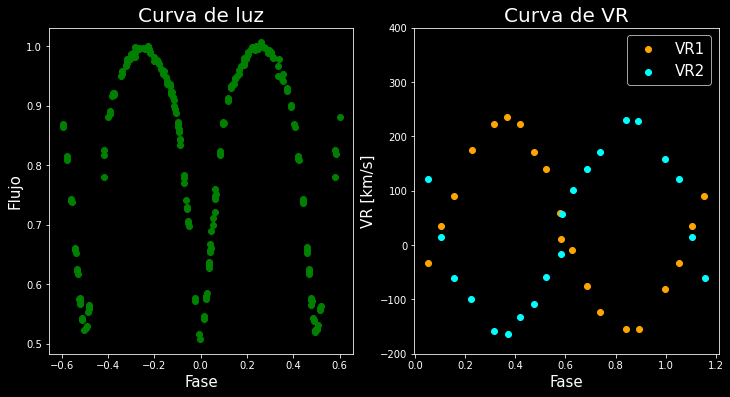

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

ax[0].scatter(pha, fl, color='green')

ax[1].scatter(pha1, v1, color='orange', label='VR1')
ax[1].scatter(pha2, v2, color='cyan', label='VR2')


ax[0].set_title('Curva de luz', fontsize=20)
ax[1].set_title('Curva de VR', fontsize=20)
ax[0].set_xlabel('Fase', fontsize=15)
ax[1].set_xlabel('Fase', fontsize=15)
ax[0].set_ylabel('Flujo', fontsize=15)
ax[1].set_ylabel('VR [km/s]', fontsize=15)
ax[1].set_ylim(-200, 400)
ax[1].legend(fontsize=15);

In [7]:
# No sé para qué son estas lineas:
b.set_value('latex_repr', component='binary', value='orb')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')

# Curva de luz, dataset
b.add_dataset('lc', times=pha, fluxes=fl, sigmas=errfl, dataset='lc01', overwrite=True)

# Velocidad radial, dataset
b.add_dataset('rv', 
              times={'primary': pha1, 'secondary': pha2},  
              rvs={'primary': v1, 'secondary': v2},
              sigmas={'primary': errv1, 'secondary': errv2}, 
              dataset='rv01',
              overwrite=True)

<ParameterSet: 81 parameters | contexts: figure, compute, constraint, dataset>

Comienzo de ajuste

Al parecer usan toda una "cadena" para llegar a hacer el ajuste. La primera parte es usar muchos estimadores para llegar a unos valores de los parámetros que estén cerca del mínimo global de Chi2. Con eso crean PRIORS gaussianos y, finalmente, usan las cadenas de Markov para terminar el ajuste

En otras palabras: no hacen directamente las cadenas de Markov, sino que hacen muchos pasos previos para acercarse a la solución correcta y sólo entonces usar las cadenas de Markov para muestrear los posteriors


In [8]:
""" PRIMER ESTIMADOR """
# Estimador VR
b.add_solver('estimator.rv_geometry', rv='rv01');
b.run_solver(kind='rv_geometry', solution='rv_geom_sol');
# Estimador LC
b.add_solver('estimator.lc_geometry', lc='lc01');
b.run_solver(kind='lc_geometry', solution='lc_geom_sol', overwrite=True);

# Se adoptan las soluciones para proseguir:
b.flip_constraint('asini@binary', solve_for='sma@binary'); # Si no se corre, da error
b.adopt_solution('lc_geom_sol');
b.adopt_solution('rv_geom_sol');

Mon, 09 Nov 2020 11:37 BUNDLE       WARNING 'rv' not a recognized kwarg
Mon, 09 Nov 2020 11:38 BUNDLE       WARNING 'lc' not a recognized kwarg
/home/matt/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9952: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)
Mon, 09 Nov 2020 11:38 BUNDLE       WARNING solution='lc_geom_sol' is not included in run_checks_solution@setting, so will not raise interactive warnings
Mon, 09 Nov 2020 11:38 BUNDLE       WARNING solution='rv_geom_sol' is not included in run_checks_solution@setting, so will not raise interactive warnings


In [9]:
plt.style.use('classic')

Mon, 09 Nov 2020 11:38 PARAMETERS   WARNING assuming you meant 'c' instead of 'color'


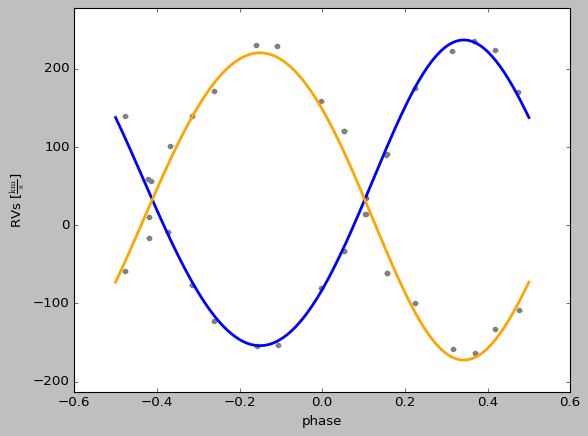

Mon, 09 Nov 2020 11:38 PARAMETERS   WARNING assuming you meant 'c' instead of 'color'
/home/matt/anaconda3/lib/python3.7/site-packages/phoebe/dependencies/autofig/call.py:1097: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array([x, y])
/home/matt/anaconda3/lib/python3.7/site-packages/phoebe/dependencies/autofig/call.py:1098: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  points = np.array([x, y]).T.reshape(-1, 1, 2)


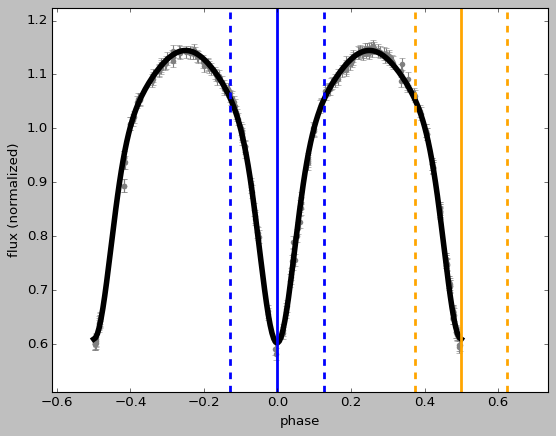

In [10]:
# Figuras
plt.style.use('classic')
afig, mplfig = b.plot(solution='rv_geom_sol', show=True, color='white');
afig, mplfig = b.plot(solution='lc_geom_sol', show=True, color='white');

In [11]:
""" SEGUNDO ESTIMADOR (EBAI) """
# Estimador LC
b.add_solver('estimator.ebai', lc='lc01')
b.run_solver(kind='ebai', solution='ebai_sol')
# # Se adopta el resultado
b.adopt_solution('ebai_sol', trial_run=True)

Mon, 09 Nov 2020 11:38 BUNDLE       WARNING adding teffratio constraint to binary orbit (needed for ebai solver)
Mon, 09 Nov 2020 11:38 BUNDLE       WARNING adding requivsumfrac constraint to binary orbit (needed for ebai solver)
Mon, 09 Nov 2020 11:39 BUNDLE       WARNING 'lc' not a recognized kwarg
Mon, 09 Nov 2020 11:39 SOLVER       WARNING ebai: eclipse width over 0.25 detected.  Returning all nans


UnboundLocalError: local variable 't0_supconj_param' referenced before assignment

In [12]:
# Se grafica el modelo con los parámetros obtenidos hasta ahora para ver cómo va
# Cálculo:
b.set_value_all('pblum_mode', 'dataset-scaled')
b.run_compute(irrad_method='none', model='after_estimators', overwrite=True)

100%|██████████| 252/252 [00:23<00:00, 10.87it/s]


<ParameterSet: 8 parameters | kinds: lc, rv>

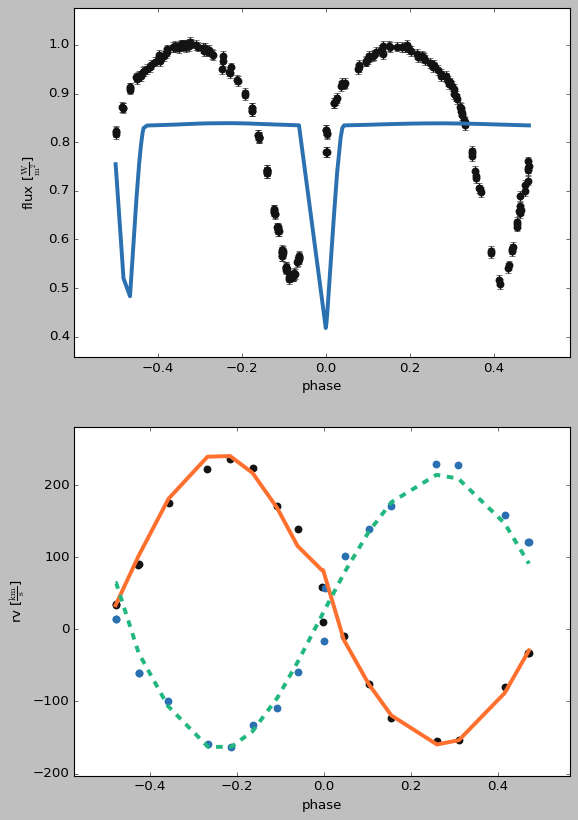

In [13]:
# Gráfico
_ = b.plot(x='phases', m='.', show=True)

In [14]:
""" TERCER ESTIMADOR (SIMPLEX)"""
b.add_compute('ellc', compute='fastcompute')
b.add_solver('optimizer.nelder_mead',
             fit_parameters=['teffratio', 'requivsumfrac', 'incl@binary', 'q', 'ecc', 'per0'],
             compute='fastcompute')
b.run_solver(kind='nelder_mead', maxiter=1000, solution='nm_sol')

Mon, 09 Nov 2020 11:39 BUNDLE       WARNING ld_mode='interp' not supported by 'ellc' backend used by compute='fastcompute'.  Change ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Mon, 09 Nov 2020 11:39 BUNDLE       WARNING ld_mode='interp' not supported by 'ellc' backend used by compute='fastcompute'.  Change ld_mode@primary@rv01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Mon, 09 Nov 2020 11:39 BUNDLE       WARNING ld_mode='interp' not supported by 'ellc' backend used by compute='fastcompute'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Mon, 09 Nov 2020 11:39 BUNDLE       WARNING ld_mode='interp' not supported by 'ellc' backend used by compute='fastcompute'.  Change ld_mode@secondary@rv01.  If not addressed, this warning will continue to be raised and will throw an error 

ValueError: failed to pass checks
Run Checks Report: FAIL
ERROR: ld_mode='interp' not supported by 'ellc' backend used by compute='fastcompute'.  Change ld_mode@primary@lc01. (2 affected parameters, affecting run_compute)
ERROR: ld_mode='interp' not supported by 'ellc' backend used by compute='fastcompute'.  Change ld_mode@primary@rv01. (2 affected parameters, affecting run_compute)
ERROR: ld_mode='interp' not supported by 'ellc' backend used by compute='fastcompute'.  Change ld_mode@secondary@lc01. (2 affected parameters, affecting run_compute)
ERROR: ld_mode='interp' not supported by 'ellc' backend used by compute='fastcompute'.  Change ld_mode@secondary@rv01. (2 affected parameters, affecting run_compute)
ERROR: fit_parameters contains the constrained parameter 'teffratio@binary@orbit@component' (2 affected parameters, affecting run_solver)
ERROR: fit_parameters contains the constrained parameter 'requivsumfrac@binary@orbit@component' (2 affected parameters, affecting run_solver)